<a href="https://colab.research.google.com/github/leeh-nix/air-quality-index-prediction/blob/main/AQI_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
# dataset_path = pathlib.Path(
#     "/content/drive/MyDrive/"
# )
df = pd.read_csv("weather_dataset.csv")
dataset = df

## Preprocessing

In [3]:
columns_to_drop = [
    "last_updated",
    "last_updated_epoch",
    "wind_direction",
    "sunrise",
    "sunset",
    "moonrise",
    "moonset",
    "moon_phase",
    "moon_illumination",
    "feels_like_celsius",
    "feels_like_fahrenheit",
    "precip_in",
    "temperature_fahrenheit",
    "pressure_in",
    "timezone",
]
dataset = dataset.drop(columns=columns_to_drop)

us_dataset = dataset.drop(
    columns=["air_quality_gb-defra-index", "visibility_km", "gust_kph", "wind_kph"]
)

gb_dataset = dataset.drop(
    columns=["air_quality_us-epa-index", "visibility_miles", "gust_mph", "wind_mph"]
)

In [4]:
# Display columns of dataset
# print(df.columns)
# print(dataset.columns)
# print(us_dataset.columns)
# print(gb_dataset.columns)


In [5]:
# gb_dataset = gb_dataset.drop(columns=[""])
gb_dataset.columns

Index(['country', 'location_name', 'region', 'latitude', 'longitude',
       'temperature_celsius', 'condition_text', 'wind_kph', 'wind_degree',
       'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'visibility_km',
       'uv_index', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_gb-defra-index'],
      dtype='object')

In [6]:
X = gb_dataset.iloc[:, :-1]
y = gb_dataset.iloc[:, -1]
print(X.columns)
print(y)

Index(['country', 'location_name', 'region', 'latitude', 'longitude',
       'temperature_celsius', 'condition_text', 'wind_kph', 'wind_degree',
       'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'visibility_km',
       'uv_index', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10'],
      dtype='object')
0         2
1         1
2         2
3         1
4         1
         ..
74438    10
74439     2
74440    10
74441     9
74442    10
Name: air_quality_gb-defra-index, Length: 74443, dtype: int64


### One Hot Encoding

In [7]:
columns_to_encode = ["country", "location_name", "region", "condition_text"]
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_columns = encoder.fit_transform(X[columns_to_encode])
X_encoded = pd.DataFrame(
    encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode)
)
X = pd.concat([X, X_encoded], axis=1)
X = X.drop(columns=columns_to_encode)

print(X.head())

   latitude  longitude  temperature_celsius  wind_kph  wind_degree  \
0     24.57      77.72                 27.5      20.5          281   
1     23.33      77.80                 27.5      15.5          287   
2     22.07      78.93                 26.3      18.4          317   
3     21.86      77.93                 25.6      16.9          297   
4     22.75      77.72                 27.2      16.2          274   

   pressure_mb  precip_mm  humidity  cloud  visibility_km  ...  \
0       1008.0        0.0        67     26           10.0  ...   
1       1008.0        0.0        70     19           10.0  ...   
2       1009.0        0.0        70     51           10.0  ...   
3       1009.0        0.0        76     65           10.0  ...   
4       1009.0        0.0        74     82           10.0  ...   

   condition_text_Patchy light rain  \
0                               0.0   
1                               0.0   
2                               0.0   
3                         

In [8]:
X.shape

(74443, 631)

### Splitting

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(59554, 631) (14889, 631) (59554,) (14889,)


## Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [12]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = model_lr.predict(X_test)

In [13]:
# Evaluate the model_1
mse = mean_squared_error(y_test, y_pred_lr)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 4.335219262706769


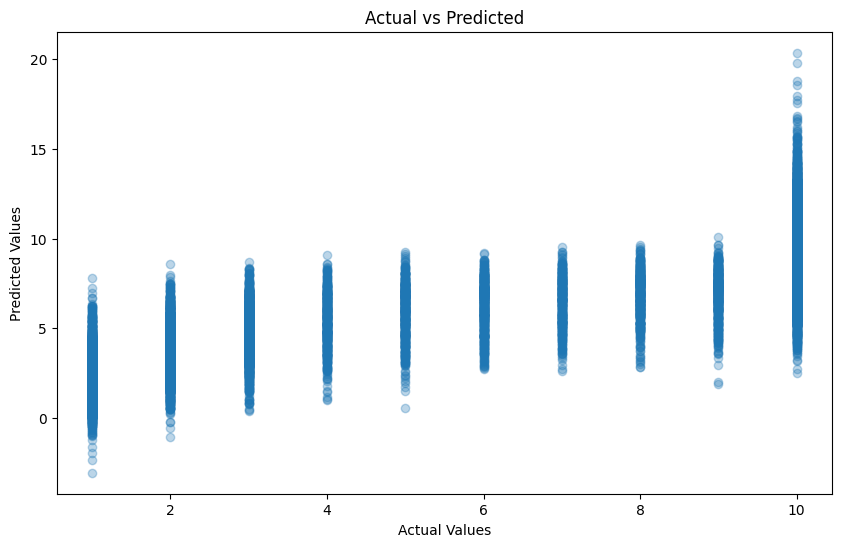

In [14]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

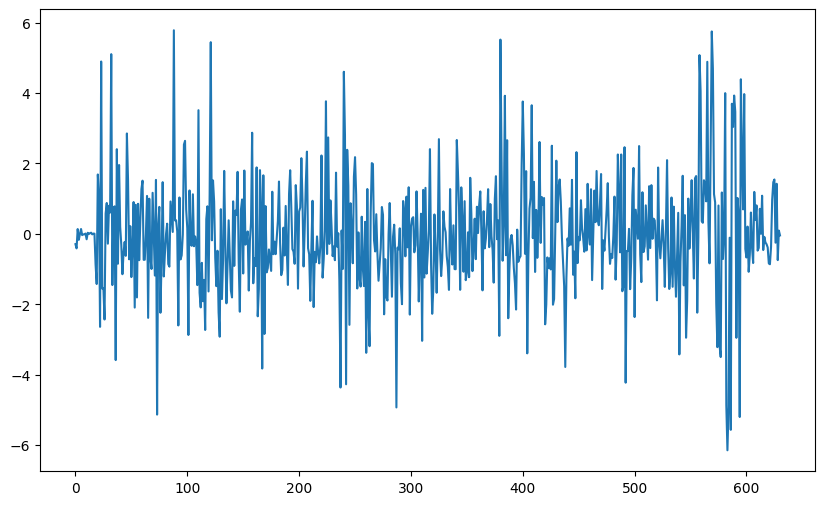

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(model_lr.coef_)
plt.show()

## Neural Network Model

In [16]:
import tensorflow as tf

# Define the model
model_nn = tf.keras.models.Sequential()
model_nn.add(tf.keras.layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)))
model_nn.add(tf.keras.layers.Dense(64, activation="relu"))
model_nn.add(tf.keras.layers.Dense(1))  # Output layer with 1 neuron for regression

# Compile the model_nn
model_nn.compile(
    optimizer="adam", loss="mean_squared_error"
)  # Use mean squared error for regression

# Train the model_nn
history = model_nn.fit(
    X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test)
)

# Evaluate the model_nn
loss = model_nn.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {loss:.2f}")

# Make predictions
y_pred = model_nn.predict(X_test)

Epoch 1/10
1862/1862 [==============================] - 10s 5ms/step - loss: 16.2483 - val_loss: 0.6310
Epoch 2/10
1862/1862 [==============================] - 8s 4ms/step - loss: 2.4299 - val_loss: 2.7850
Epoch 3/10
1862/1862 [==============================] - 9s 5ms/step - loss: 1.8145 - val_loss: 0.2369
Epoch 4/10
1862/1862 [==============================] - 8s 4ms/step - loss: 1.2657 - val_loss: 0.4993
Epoch 5/10
1862/1862 [==============================] - 7s 4ms/step - loss: 0.1618 - val_loss: 0.0830
Epoch 6/10
1862/1862 [==============================] - 9s 5ms/step - loss: 0.1501 - val_loss: 0.0761
Epoch 7/10
1862/1862 [==============================] - 8s 4ms/step - loss: 0.1693 - val_loss: 0.0627
Epoch 8/10
1862/1862 [==============================] - 8s 4ms/step - loss: 0.0759 - val_loss: 0.0493
Epoch 9/10
1862/1862 [==============================] - 8s 4ms/step - loss: 0.1241 - val_loss: 0.0460
Epoch 10/10
466/466 [==============================] - 1s 2ms/step - loss: 0.048

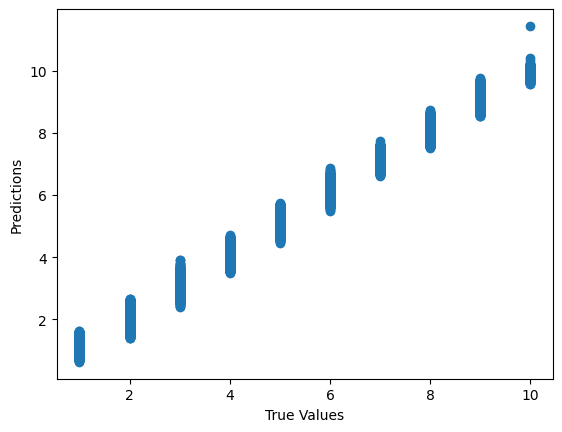

In [17]:
# Plotting the true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

Text(0, 0.5, 'Loss')

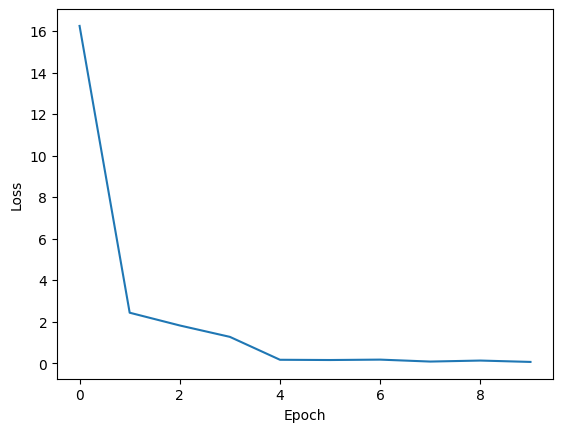

In [18]:
# visualize the model
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")